## Imports

In [1]:
import itertools
import json
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import numpy as np
import pandas as pd
import re
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from spellchecker import SpellChecker
from joblib import dump, load

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Khaled\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Khaled\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import time
import datetime

In [3]:
# Beep when notebook stops running code
import winsound
def beep(reps=1, duration=500, freq=440, sleep=1):
    for _ in range(reps - 1):
        winsound.Beep(freq, duration)
        time.sleep(sleep)
    winsound.Beep(freq, duration)

## Data

Load the cleaned reviews:

In [4]:
%%time
data = "dataset/preprocessed_dataset.csv"
df = pd.read_csv(data)
df = df[df.reviewText.notna()]
df.head()

Wall time: 7.03 s


In [5]:
df.shape

(1127630, 4)

See proportion of positive ($>3$) and critical ($\leq 3$) reviews:

In [7]:
df.groupby("positive").size()

positive
False    236880
True     890750
dtype: int64

In [8]:
df.groupby("positive").size()/(df.shape[0])

positive
False    0.210069
True     0.789931
dtype: float64

The class to predict is highly unbalanced. We can sample in order to have a balanced class:

In [9]:
sample_size = 500000 # needs to be less than the number of observations in the minority class
sample_df = df.groupby('positive').apply(lambda x: x.sample(sample_size))

In [10]:
sample_df = sample_df.reset_index(level=0, drop=True) # remove outer level of multiindex

In [11]:
sample_df.groupby("positive").size()

positive
False    200000
True     200000
dtype: int64

#### Choice: Unbalanced or Balanced Classes

Definition of unbalanced `X` and `y` (class to predict). The classification with this choice should be better at predicting sentiment on the reviews from the Amazon dataset.

In [12]:
# X = df.reviewTextPreprocessed.values
# y = df.positive.values

Definition of balanced `X` and `y` (class to predict). The classification with this choice should be better at predicting sentiment on tweets (which might not be unbalanced in the same way as this dataset).

In [13]:
X = sample_df.reviewTextPreprocessed.values
y = sample_df.positive.values

## Order of operations from now on:

First of all, we define a list of stopwords.

The next step is the preprocessing needed to obtain a suitable representation of the reviews, which are:

- Tokenization
- Spelling correction
- Stop words removal
- Stemming

After these operations, the reviews are going to be passed to a vectorizer in order to obtain the final representation for the classifiers.

Stemming can be achieved using two different libraries: NLTK and PyStemmer. PyStemmer is faster, but needs Visual C++ Build Tools installed. Please choose the relevant code you prefer to run.

#### Rough execution times:

(Execution times might be different from the following, I ran the notebook again afterwards)

#### NLTK

- Tokenization, 3min 15s
- Spell check and correction, 14min 11s (`proprocessor` parameter)
- Stop words removal, 1min 6s (`stop_words` parameter)
- Stemming, 7min 10s (Porter) 5min 56s (Lancaster)
- Vectorization, 58.8 s (Porter), 56.6 s(Lancaster)

#### PyStemmer

Class that performs

- Tokenization
- Spell check and correction (parameter `preprocessor`)
- Stop words removal (parameter `stop_words`)
- Stemming (with `pystemmer`)
- Vectorization

8min 49s

### Definition of the list of Stop-words

In [14]:
from nltk.corpus import stopwords
stopws = stopwords.words("english")

The list of stop words needs to be preprocessed in the same way as the reviews. We define the  dictionaries needed for the preprocessing, as in the previous notebook:

In [15]:
emoticon_repl = {
    # positive emoticons
    r":-?d+": " good ",  r":[- ]?\)+": " good ", r";-?\)+": " good ",
    r"\(+-?:": " good ", r"=\)+" : " good ", r"<3" : " good ",
    # negative emoticons
    r"[\s\r\t\n]+:/+": " bad ", r":\\+": " bad ", r"[\s\r\t\n]+\)-?:": " bad ",
    r":-?\(+": " bad ", r"[\s\t\r\n]+d+-?:": " bad "
}

contracted_repl = {
    # casi particolari
    r"won\'t" : "will not", r"won\'" : "will not", r"can\'t": "can not", r"shan\'t": "shall not",
    r"shan\'": "shall not", r"ain\'t": "is not", r"ain\'": "is not",
    # casi generali
    r"n\'t": " not", r"\'t": " not", r"n\'": " not", r"\'s": " is", r"\'ve": " have", 
    r"\'re": " are", 
    r"\'ll": " will", r"\'d": " would",
}

with open('dataset/slang_subset_manual.json', 'r') as fid:
    slang_repl = json.load(fid)

Same preprocessing function as in the previous notebook:

In [16]:
def preprocess(sent, translate_slang = True):
    
    sent = sent.lower()
    sent = re.sub(r'^<div id="video.*>&nbsp;', '', sent) # Video-review part
    sent = re.sub('https?://[A-Za-z0-9./]+', '', sent) # URLs
    
    for k in emoticon_repl:
        sent = re.sub(k, emoticon_repl[k], sent)

    if translate_slang:
        for k in slang_repl:
            sent = re.sub(r"\b"+re.escape(k)+r"\b", slang_repl[k], sent)
        
    for k in contracted_repl:
        sent = re.sub(k, contracted_repl[k], sent)
    
    sent = re.sub('[/]+', ' ', sent) # word1/word2 to word1 word2
    sent = re.sub('[^A-Za-z0-9-_ ]+', '', sent)
    sent = re.sub('\b\d+\b', '', sent)
    
    return sent

In [17]:
prep_stopws = [preprocess(el) for el in stopws]

Words containing "not" are important for our tasks

In [18]:
np.array(prep_stopws[-36:])

array(['ain', 'aren', 'are not', 'couldn', 'could not', 'didn', 'did not',
       'doesn', 'does not', 'hadn', 'had not', 'hasn', 'has not', 'haven',
       'have not', 'isn', 'is not', 'ma', 'mightn', 'might not', 'mustn',
       'must not', 'needn', 'need not', 'shan', 'shall not', 'shouldn',
       'should not', 'wasn', 'was not', 'weren', 'were not', 'won',
       'will not', 'wouldn', 'would not'], dtype='<U10')

In [19]:
prep_stopws = prep_stopws[:-36]

Other words to remove from the stop words:

In [20]:
for word in ["not", "very", "don", "do not"]:
    prep_stopws.remove(word)

In [21]:
prep_stopws.extend(["youse", "would"]) # needed for consistency with spell checker

## Tokenization/Spell Correction/StopWordsRemoval/Stemming

### NLTK

In [22]:
from nltk.tokenize import word_tokenize
def tokenize_reviews(reviews):
    tokenized_reviews = [word_tokenize(review) for review in reviews]
    return tokenized_reviews

In [23]:
%%time
X_tokenized = tokenize_reviews(X)

Wall time: 1min 23s


Spelling correction:

In [24]:
def fix_spelling_mistakes(reviews, dist=1):
    spell = SpellChecker(distance=dist)
    reviews_with_right_spell = []
    for review in reviews:
        corrected_review = [spell.correction(word) for word in review]
        reviews_with_right_spell.append(corrected_review)
    return reviews_with_right_spell

In [25]:
%%time
X_spellchecked = fix_spelling_mistakes(X_tokenized)

Wall time: 8min 8s


Stop words removal:

In [26]:
%%time
X_noStopWords = []
for review in X_spellchecked:
        cleaned_review = [word for word in review if word not in prep_stopws]
        X_noStopWords.append(cleaned_review)

Wall time: 22.6 s


In [27]:
from nltk.stem import PorterStemmer, LancasterStemmer

In [28]:
def stem_reviews(reviews, stemmer_name="Porter"):
    if stemmer_name == "Porter":
        stemmer = PorterStemmer()
    elif stemmer_name == "Lancaster":
        stemmer = LancasterStemmer()
    else:
        raise SystemError
    stemmed_reviews = []
    for review in reviews:
        stemmed_reviews.append([stemmer.stem(word) for word in review])
    return stemmed_reviews

In [29]:
%%time
X_Porter = stem_reviews(X_noStopWords, stemmer_name = "Porter")

Wall time: 2min 57s


In [30]:
%%time
X_Lancaster = stem_reviews(X_noStopWords, stemmer_name = "Lancaster")

Wall time: 2min 29s


### PyStemmer (needs Visual C++ installed)

Definition of the class StemmedTdidfVectorized.

- `sklearn`'s `TfidfVectorizer` takes care of tokenization, stop-word removal, vectorization
- `pystemmer` takes care of stemming.

In [31]:
import Stemmer
english_stemmer = Stemmer.Stemmer('en')

In [32]:
class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(TfidfVectorizer, self).build_analyzer()
        return lambda doc: english_stemmer.stemWords(analyzer(doc))

## Train-test split

In [33]:
from sklearn.model_selection import train_test_split

#### NLTK

Here we are train/test splitting the set of reviews that is already tokenized and stemmed, to be passed to TfidfVectorizer for representation.

In [34]:
X_train_Porter, X_test_Porter, y_train, y_test = train_test_split(X_Porter, y,
                                                                  test_size=0.33, random_state=42)
X_train_Lancaster, X_test_Lancaster, y_train, y_test = train_test_split(X_Lancaster, y,
                                                                        test_size=0.33, random_state=42)

#### Pystemmer

Here we are train/test splitting the preprocessed set of reviews to be passed to `StemmedTfidfVectorizer` for tokenization+stemming+representation.

In [35]:
X_train_pystemmer, X_test_pystemmer, y_train, y_test = train_test_split(X, y,
                                                                  test_size=0.33, random_state=42)

## Text Representation

#### NLTK

In [36]:
def rebuild_reviews(reviews):
    rebuilt_reviews = []
    for review in reviews:
        rebuilt_reviews.append(" ".join(review))
    return rebuilt_reviews

In [37]:
X_train_Porter = rebuild_reviews(X_train_Porter)
X_test_Porter = rebuild_reviews(X_test_Porter)
X_train_Lancaster = rebuild_reviews(X_train_Lancaster)
X_test_Lancaster = rebuild_reviews(X_test_Lancaster)

In [38]:
%%time
tfidf_vect_Porter = TfidfVectorizer(min_df= 5, max_features = 50000, ngram_range=(1,2))
X_train_tfidf_Porter = tfidf_vect_Porter.fit_transform(X_train_Porter)

Wall time: 18.1 s


In [39]:
%%time
X_test_tfidf_Porter = tfidf_vect_Porter.transform(X_test_Porter)

Wall time: 5.28 s


In [40]:
%%time
tfidf_vect_Lancaster = TfidfVectorizer(min_df= 5, max_features = 50000, ngram_range=(1,2))
X_train_tfidf_Lancaster = tfidf_vect_Lancaster.fit_transform(X_train_Lancaster)

Wall time: 17.5 s


In [41]:
%%time
X_test_tfidf_Lancaster = tfidf_vect_Lancaster.transform(X_test_Lancaster)

Wall time: 5.26 s


In [42]:
dump(tfidf_vect_Porter, 'joblib_data/tfidf_vect_Porter.joblib')
dump(tfidf_vect_Lancaster, 'joblib_data/tfidf_vect_Lancaster.joblib')

['joblib_data/tfidf_vect_Lancaster.joblib']

#### Pystemmer

In [43]:
%%time
spell = SpellChecker(distance=1)
tfidf_vect_pystemmer = StemmedTfidfVectorizer(min_df= 5, max_features = 50000, ngram_range=(1,2),
                                              preprocessor = spell.correction,
                                              stop_words = prep_stopws)
X_train_tfidf_pystemmer = tfidf_vect_pystemmer.fit_transform(X_train_pystemmer)

Wall time: 2min 7s


In [44]:
%%time
X_test_tfidf_pystemmer = tfidf_vect_pystemmer.transform(X_test_pystemmer)

Wall time: 56.6 s


In [45]:
dump(tfidf_vect_pystemmer, 'joblib_data/tfidf_vect_pystemmer.joblib') 

['joblib_data/tfidf_vect_pystemmer.joblib']

In [46]:
beep()

####  No stemming

In [47]:
X_train_nostemmer, X_test_nostemmer, y_train, y_test = train_test_split(X, y,
                                                                  test_size=0.33, random_state=42)

In [48]:
%%time
spell = SpellChecker(distance=1)
tfidf_vect_nostemmer = TfidfVectorizer(min_df= 5, max_features = 50000, ngram_range=(1,2),
                                              preprocessor = spell.correction,
                                              stop_words = prep_stopws)
X_train_tfidf_nostemmer = tfidf_vect_nostemmer.fit_transform(X_train_nostemmer)

Wall time: 1min 36s


In [49]:
%%time
X_test_tfidf_nostemmer = tfidf_vect_nostemmer.transform(X_test_nostemmer)

Wall time: 41.7 s


In [50]:
dump(tfidf_vect_nostemmer, 'joblib_data/tfidf_vect_nostemmer.joblib') 

['joblib_data/tfidf_vect_nostemmer.joblib']

In [51]:
beep()

# Classification

## NB Classifier

In [52]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix, f1_score, fbeta_score, precision_score, recall_score

Accessory functions:

In [53]:
def print_top_features(vectorizer, clf, n = 10):
    fnames = vectorizer.get_feature_names()
    top_pos = np.argsort(clf.coef_[0])[-n:]
    top_pos = top_pos[::-1]
    print("Most discriminative features:\n",
          ", ".join(fnames[j] for j in top_pos))

In [54]:
def score_NB(clf, X_train, X_test, y_train, y_test):
    train_score = clf.score(X_train, y_train) # Train Accuracy
    test_score = clf.score(X_test, y_test)    # Test Accuracy
    
    predictions = clf.predict(X_test)

    prec = precision_score(y_test, predictions) # Precision
    rec = recall_score(y_test, predictions) # Recall
    f1 = f1_score(y_test, predictions) # F1
    f2 = fbeta_score(y_test, predictions, 2) # F2
    cm = confusion_matrix(y_test, predictions)
    
    proba = clf.predict_proba(X_test)

    precision, recall, pr_thresholds = precision_recall_curve(y_test, proba[:,1])
    
    auc_score = auc(recall, precision)
    
    scores_strings = ["Train Accuracy", "Test Accuracy", "Test Precision",
                      "Test Recall", "F1", "F2", "P/R AUC"]
    
    scores = [train_score, test_score, prec, rec, f1, f2, auc_score]
    
    print(("{:20s} {:.5f}\n"*7)[:-1].format(*itertools.chain(*zip(scores_strings, scores))))
    
    print(classification_report(y_test, predictions, digits=5))
    
    plt.plot(recall, precision, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve: AUC=%0.2f' % auc_score)
    plt.legend(loc="lower left")
    plt.show()

###  No Stemmer

In [55]:
%%time
clf = MultinomialNB()
clf.fit(X_train_tfidf_nostemmer, y_train)

Wall time: 79.6 ms


In [56]:
print_top_features(tfidf_vect_nostemmer, clf, 50)

Most discriminative features:
 great, good, case, love, phone, very, works, not, product, nice, excellent, perfect, well, like, screen, one, fits, works great, price, easy, quality, great product, use, fit, really, very good, iphone, perfectly, protector, protection, looks, awesome, recommend, charger, time, charge, best, bought, get, little, fast, battery, buy, ok, screen protector, great case, work, much, thanks, still


Train Accuracy       0.87014
Test Accuracy        0.85757
Test Precision       0.86313
Test Recall          0.84922
F1                   0.85612
F2                   0.85197
P/R AUC              0.92833
             precision    recall  f1-score   support

      False       0.85      0.87      0.86     66135
       True       0.86      0.85      0.86     65865

avg / total       0.86      0.86      0.86    132000



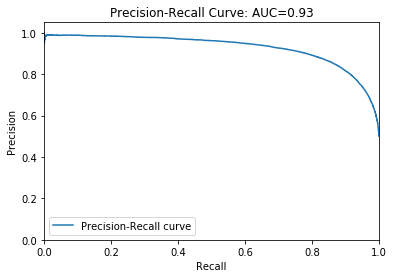

Wall time: 453 ms


In [57]:
%%time
score_NB(clf, X_train_tfidf_nostemmer, X_test_tfidf_nostemmer, y_train, y_test)

In [58]:
beep()

In [59]:
dump(clf, 'joblib_data/clf_nb_nostemmer.joblib') 

['joblib_data/clf_nb_nostemmer.joblib']

### NLTK

#### Porter

In [60]:
%%time
clf = MultinomialNB()
clf.fit(X_train_tfidf_Porter, y_train)

Wall time: 86.2 ms


In [61]:
print_top_features(tfidf_vect_Porter, clf, 50)

Most discriminative features:
 great, good, love, case, phone, work, veri, product, not, nice, excel, fit, like, perfect, well, protect, use, work great, charg, one, screen, look, price, easi, thank, great product, qualiti, protector, time, veri good, realli, recommend, perfectli, get, need, charger, screen protector, awesom, buy, batteri, color, best, feel, bought, expect, cabl, fast, littl, cover, ok


Train Accuracy       0.86770
Test Accuracy        0.85543
Test Precision       0.86074
Test Recall          0.84737
F1                   0.85400
F2                   0.85001
P/R AUC              0.92692
             precision    recall  f1-score   support

      False       0.85      0.86      0.86     66135
       True       0.86      0.85      0.85     65865

avg / total       0.86      0.86      0.86    132000



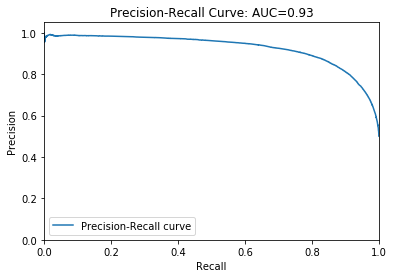

Wall time: 437 ms


In [62]:
%%time
score_NB(clf, X_train_tfidf_Porter, X_test_tfidf_Porter, y_train, y_test)

In [63]:
dump(clf, 'joblib_data/clf_nb_porter.joblib') 

['joblib_data/clf_nb_porter.joblib']

#### Lancaster

In [64]:
%%time
clf = MultinomialNB()
clf.fit(X_train_tfidf_Lancaster, y_train)

Wall time: 78.1 ms


In [65]:
print_top_features(tfidf_vect_Lancaster, clf, 50)

Most discriminative features:
 gre, good, lov, cas, phon, work, excel, very, not, perfect, produc, protect, nic, charg, fit, lik, us, wel, work gre, on, screen, easy, look, pric, thank, gre produc, qual, real, tim, very good, recommend, get, nee, screen protect, awesom, buy, battery, fast, col, best, feel, cov, bought, expect, cabl, littl, hold, ok, drop, gre cas


Train Accuracy       0.86670
Test Accuracy        0.85445
Test Precision       0.85982
Test Recall          0.84626
F1                   0.85299
F2                   0.84894
P/R AUC              0.92568
             precision    recall  f1-score   support

      False       0.85      0.86      0.86     66135
       True       0.86      0.85      0.85     65865

avg / total       0.85      0.85      0.85    132000



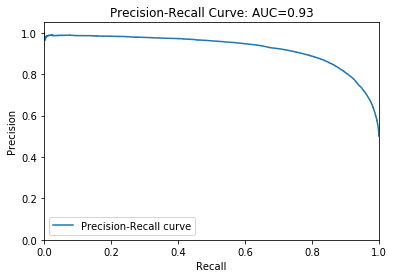

Wall time: 437 ms


In [66]:
%%time
score_NB(clf, X_train_tfidf_Lancaster, X_test_tfidf_Lancaster, y_train, y_test)

In [67]:
dump(clf, 'joblib_data/clf_nb_lancaster.joblib') 

['joblib_data/clf_nb_lancaster.joblib']

###  PyStemmer

In [68]:
%%time
clf = MultinomialNB()
clf.fit(X_train_tfidf_pystemmer, y_train)

Wall time: 78.1 ms


In [69]:
print_top_features(tfidf_vect_pystemmer, clf, 50)

Most discriminative features:
 great, good, love, case, phone, work, veri, perfect, product, not, nice, excel, fit, like, well, protect, use, charg, one, screen, look, works great, price, easi, thank, great product, qualiti, protector, time, iphon, realli, very good, recommend, get, need, charger, screen protector, buy, awesom, batteri, color, best, feel, bought, cabl, fast, littl, expect, cover, ok


Train Accuracy       0.86881
Test Accuracy        0.85700
Test Precision       0.86217
Test Recall          0.84916
F1                   0.85562
F2                   0.85173
P/R AUC              0.92764
             precision    recall  f1-score   support

      False       0.85      0.86      0.86     66135
       True       0.86      0.85      0.86     65865

avg / total       0.86      0.86      0.86    132000



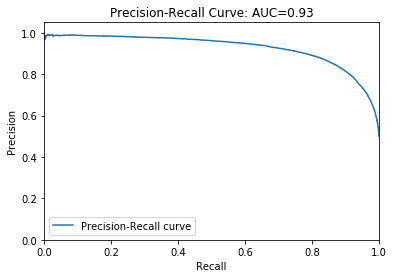

Wall time: 422 ms


In [70]:
%%time
score_NB(clf, X_train_tfidf_pystemmer, X_test_tfidf_pystemmer, y_train, y_test)

In [71]:
dump(clf, 'joblib_data/clf_nb_pystemmer.joblib') 

['joblib_data/clf_nb_pystemmer.joblib']

## Random forest

In [72]:
from sklearn.ensemble import RandomForestClassifier

### No stemmer

In [73]:
%%time
clf = RandomForestClassifier(n_estimators=40, random_state=42, n_jobs=-1)
clf.fit(X_train_tfidf_nostemmer, y_train)

Wall time: 8min 30s


In [74]:
train_score = clf.score(X_train_tfidf_nostemmer, y_train) # Train Accuracy
test_score = clf.score(X_test_tfidf_nostemmer, y_test)    # Test Accuracy
print("Train accuracy: {}, test accuracy: {}".format(train_score, test_score))

Train accuracy: 0.983339552238806, test accuracy: 0.8461818181818181


In [75]:
%%time
predictions = clf.predict(X_test_tfidf_nostemmer)

Wall time: 1.78 s


In [76]:
print(classification_report(y_test, predictions, digits=5))
dump(clf, "joblib_data/clf_random_forest_nostemmer.joblib")

             precision    recall  f1-score   support

      False       0.83      0.88      0.85     66135
       True       0.87      0.81      0.84     65865

avg / total       0.85      0.85      0.85    132000



['clf_random_forest_nostemmer.joblib']

### Porter

In [77]:
%%time
clf = RandomForestClassifier(n_estimators=40, random_state=42, n_jobs=-1)
clf.fit(X_train_tfidf_Porter, y_train)

Wall time: 8min 26s


In [78]:
train_score = clf.score(X_train_tfidf_Porter, y_train) # Train Accuracy
test_score = clf.score(X_test_tfidf_Porter, y_test)    # Test Accuracy
print("Train accuracy: {}, test accuracy: {}".format(train_score, test_score))

Train accuracy: 0.983294776119403, test accuracy: 0.844719696969697


In [79]:
%%time
predictions = clf.predict(X_test_tfidf_Porter)

Wall time: 1.77 s


In [80]:
print(classification_report(y_test, predictions, digits=5))
dump(clf, "joblib_data/clf_random_forest_porter.joblib")

             precision    recall  f1-score   support

      False       0.82      0.88      0.85     66135
       True       0.87      0.81      0.84     65865

avg / total       0.85      0.84      0.84    132000



['clf_random_forest_porter.joblib']

Results are more encouraging! The problem is that it's way slower than Multinomial NB.

### Lancaster

In [81]:
%%time
clf = RandomForestClassifier(n_estimators=40, random_state=42, n_jobs=-1)
clf.fit(X_train_tfidf_Lancaster, y_train)

Wall time: 8min 36s


In [82]:
train_score = clf.score(X_train_tfidf_Lancaster, y_train) # Train Accuracy
test_score = clf.score(X_test_tfidf_Lancaster, y_test)    # Test Accuracy
print("Train accuracy: {}, test accuracy: {}".format(train_score, test_score))

Train accuracy: 0.9832164179104478, test accuracy: 0.8441060606060606


In [83]:
%%time
predictions = clf.predict(X_test_tfidf_Lancaster)

Wall time: 1.72 s


In [84]:
print(classification_report(y_test, predictions, digits=5))
dump(clf, "joblib_data/clf_random_forest_lancaster.joblib")

             precision    recall  f1-score   support

      False       0.82      0.88      0.85     66135
       True       0.87      0.81      0.84     65865

avg / total       0.85      0.84      0.84    132000



['clf_random_forest_lancaster.joblib']

### Pystemmer

In [85]:
%%time
clf = RandomForestClassifier(n_estimators=40, random_state=42, n_jobs=-1)
clf.fit(X_train_tfidf_pystemmer, y_train)

Wall time: 8min 20s


In [86]:
train_score = clf.score(X_train_tfidf_pystemmer, y_train) # Train Accuracy
test_score = clf.score(X_test_tfidf_pystemmer, y_test)    # Test Accuracy
print("Train accuracy: {}, test accuracy: {}".format(train_score, test_score))

Train accuracy: 0.9832686567164179, test accuracy: 0.845560606060606


In [87]:
%%time
predictions = clf.predict(X_test_tfidf_pystemmer)

Wall time: 1.81 s


In [88]:
print(classification_report(y_test, predictions, digits=5))
dump(clf, "joblib_data/clf_random_forest_pystemmer.joblib")

             precision    recall  f1-score   support

      False       0.82      0.88      0.85     66135
       True       0.87      0.81      0.84     65865

avg / total       0.85      0.85      0.85    132000



['clf_random_forest_pystemmer.joblib']

## TruncatedSVD
The X_train vector has around 20k features: for speeding up the training phase it may be good to use dimensionality reduction methods. Their goal is to preserve "expressive power" while reducing dataset dimensionality.
Because the TFIDF matrix is a sparse one, one of the best method for performing dimensionality reduction is "TruncatedSVD"

### No stemmer

In [89]:
%%time
from sklearn.decomposition import TruncatedSVD
tsvd = TruncatedSVD(n_components=500, random_state=42)
X_train_tfidf_nostemmer_svd = tsvd.fit_transform(X_train_tfidf_nostemmer)
X_test_tfidf_nostemmer_svd = tsvd.transform(X_test_tfidf_nostemmer)

Wall time: 1min 41s


### Porter

In [90]:
%%time
tsvd = TruncatedSVD(n_components=500, random_state=42)
X_train_tfidf_Porter_svd = tsvd.fit_transform(X_train_tfidf_Porter)
X_test_tfidf_Porter_svd = tsvd.transform(X_test_tfidf_Porter)

Wall time: 1min 41s


### Lancaster

In [91]:
%%time
tsvd = TruncatedSVD(n_components=500, random_state=42)
X_train_tfidf_Lancaster_svd = tsvd.fit_transform(X_train_tfidf_Lancaster)
X_test_tfidf_Lancaster_svd = tsvd.transform(X_test_tfidf_Lancaster)

Wall time: 1min 41s


### Pystemmer

In [92]:
%%time
tsvd = TruncatedSVD(n_components=500, random_state=42)
X_train_tfidf_pystemmer_svd = tsvd.fit_transform(X_train_tfidf_pystemmer)
X_test_tfidf_pystemmer_svd = tsvd.transform(X_test_tfidf_pystemmer)

Wall time: 1min 42s


#### Store SVD-transformed dataset

In [93]:
dump(X_train_tfidf_nostemmer_svd, 'joblib_data/X_train_tfidf_nostemmer_svd.joblib')
dump(X_test_tfidf_nostemmer_svd, 'joblib_data/X_test_tfidf_nostemmer_svd.joblib')

['joblib_data/X_test_tfidf_nostemmer_svd.joblib']

In [94]:
dump(X_train_tfidf_Porter_svd, 'joblib_data/X_train_tfidf_Porter_svd.joblib')
dump(X_test_tfidf_Porter_svd, 'joblib_data/X_test_tfidf_Porter_svd.joblib')

['joblib_data/X_test_tfidf_Porter_svd.joblib']

In [95]:
dump(X_train_tfidf_Lancaster_svd, 'joblib_data/X_train_tfidf_Lancaster_svd.joblib')
dump(X_test_tfidf_Lancaster_svd, 'joblib_data/X_test_tfidf_Lancaster_svd.joblib')

['joblib_data/X_test_tfidf_Lancaster_svd.joblib']

In [96]:
dump(X_train_tfidf_pystemmer_svd, 'joblib_data/X_train_tfidf_pystemmer_svd.joblib')
dump(X_test_tfidf_pystemmer_svd, 'joblib_data/X_test_tfidf_pystemmer_svd.joblib')

['joblib_data/X_test_tfidf_pystemmer_svd.joblib']

## Random Forest with TruncatedSVD Dataset

### No stemmer

In [97]:
%%time
clf = RandomForestClassifier(n_estimators=40, random_state=42, n_jobs=-1)
clf.fit(X_train_tfidf_nostemmer_svd, y_train)

Wall time: 1min 36s


In [98]:
%%time
predictions = clf.predict(X_test_tfidf_nostemmer_svd)

Wall time: 1.09 s


In [99]:
print(classification_report(y_test, predictions, digits=5))
dump(clf, "joblib_data/clf_random_forest_nostemmer_svd.joblib")

             precision    recall  f1-score   support

      False       0.78      0.83      0.81     66135
       True       0.82      0.77      0.79     65865

avg / total       0.80      0.80      0.80    132000



['clf_random_forest_nostemmer_svd.joblib']

### Porter

In [100]:
%%time
clf = RandomForestClassifier(n_estimators=40, random_state=42, n_jobs=-1)
clf.fit(X_train_tfidf_Porter_svd, y_train)

Wall time: 1min 35s


In [101]:
%%time
predictions = clf.predict(X_test_tfidf_Porter_svd)

Wall time: 1.05 s


In [102]:
print(classification_report(y_test, predictions, digits=5))
dump(clf, "joblib_data/clf_random_forest_porter_svd.joblib")

             precision    recall  f1-score   support

      False       0.79      0.83      0.81     66135
       True       0.82      0.77      0.80     65865

avg / total       0.80      0.80      0.80    132000



['clf_random_forest_porter_svd.joblib']

### Lancaster

In [103]:
%%time
clf = RandomForestClassifier(n_estimators=40, random_state=42, n_jobs=-1)
clf.fit(X_train_tfidf_Lancaster_svd, y_train)

Wall time: 1min 38s


In [104]:
%%time
predictions = clf.predict(X_test_tfidf_Lancaster_svd)

Wall time: 1.09 s


In [105]:
print(classification_report(y_test,predictions, digits=5))
dump(clf, "joblib_data/clf_random_forest_lancaster_svd.joblib")

             precision    recall  f1-score   support

      False       0.78      0.84      0.81     66135
       True       0.82      0.76      0.79     65865

avg / total       0.80      0.80      0.80    132000



['clf_random_forest_lancaster_svd.joblib']

### Pystemmer

In [106]:
%%time
clf = RandomForestClassifier(n_estimators=40, random_state=42, n_jobs=-1)
clf.fit(X_train_tfidf_pystemmer_svd, y_train)

Wall time: 1min 38s


In [107]:
%%time
predictions = clf.predict(X_test_tfidf_pystemmer_svd)

Wall time: 1.05 s


In [108]:
print(classification_report(y_test, predictions, digits=5))
dump(clf, "joblib_data/clf_random_forest_pystemmer_svd.joblib")

             precision    recall  f1-score   support

      False       0.79      0.84      0.81     66135
       True       0.82      0.77      0.80     65865

avg / total       0.80      0.80      0.80    132000



['clf_random_forest_pystemmer_svd.joblib']

## LinearSVC

In [109]:
from sklearn import svm

### No_stemmer

In [110]:
%%time
clf = svm.LinearSVC(random_state=42)
clf.fit(X_train_tfidf_nostemmer_svd, y_train)

Wall time: 26.7 s


In [111]:
%%time
predictions = clf.predict(X_test_tfidf_nostemmer_svd)

Wall time: 125 ms


In [112]:
print(classification_report(y_test, predictions, digits=5))
dump(clf, "joblib_data/clf_linearsvc_nostemmer_svd.joblib")

             precision    recall  f1-score   support

      False       0.84      0.85      0.84     66135
       True       0.84      0.83      0.84     65865

avg / total       0.84      0.84      0.84    132000



['clf_linearsvc_nostemmer_svd.joblib']

### Porter

In [113]:
%%time
clf = svm.LinearSVC(random_state=42)
clf.fit(X_train_tfidf_Porter_svd, y_train)

Wall time: 26.3 s


In [114]:
%%time
predictions = clf.predict(X_test_tfidf_Porter_svd)

Wall time: 125 ms


In [115]:
print(classification_report(y_test, predictions, digits=5))
dump(clf, "joblib_data/clf_linearsvc_porter_svd.joblib")

             precision    recall  f1-score   support

      False       0.84      0.84      0.84     66135
       True       0.84      0.84      0.84     65865

avg / total       0.84      0.84      0.84    132000



['clf_linearsvc_porter_svd.joblib']

### Lancaster

In [116]:
%%time
clf = svm.LinearSVC(random_state=42)
clf.fit(X_train_tfidf_Lancaster_svd, y_train)

Wall time: 26.8 s


In [117]:
%%time
predictions = clf.predict(X_test_tfidf_Lancaster_svd)

Wall time: 125 ms


In [118]:
print(classification_report(y_test, predictions, digits=5))
dump(clf, "joblib_data/clf_linearsvc_lancaster_svd.joblib")

             precision    recall  f1-score   support

      False       0.84      0.84      0.84     66135
       True       0.84      0.84      0.84     65865

avg / total       0.84      0.84      0.84    132000



['clf_linearsvc_lancaster_svd.joblib']

### Pystemmer

In [119]:
%%time
clf = svm.LinearSVC(random_state=42)
clf.fit(X_train_tfidf_pystemmer_svd, y_train)

Wall time: 26.3 s


In [120]:
%%time
predictions = clf.predict(X_test_tfidf_pystemmer_svd)

Wall time: 125 ms


In [121]:
print(classification_report(y_test, predictions, digits=5))
dump(clf, "joblib_data/clf_linearsvc_pystemmer_svd.joblib")

             precision    recall  f1-score   support

      False       0.84      0.84      0.84     66135
       True       0.84      0.84      0.84     65865

avg / total       0.84      0.84      0.84    132000



['clf_linearsvc_pystemmer_svd.joblib']

## SVC

### No stemmer

In [131]:
clf = svm.SVC(random_state=42, max_iter=500)

In [132]:
%%time
clf.fit(X_train_tfidf_nostemmer_svd, y_train)

Wall time: 2min 49s


c:\python\python36\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=500, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

In [133]:
%%time
predictions = clf.predict(X_test_tfidf_nostemmer_svd)

Wall time: 1min 18s


In [134]:
print(classification_report(y_test, predictions, digits=5))
dump(clf, "joblib_data/clf_svc_nostemmer_svd.joblib")

             precision    recall  f1-score   support

      False       0.89      0.05      0.10     66135
       True       0.51      0.99      0.67     65865

avg / total       0.70      0.52      0.38    132000



['clf_svc_nostemmer_svd.joblib']

### Porter

In [135]:
clf = svm.SVC(random_state=42, max_iter=500)

In [136]:
%%time
clf.fit(X_train_tfidf_Porter_svd, y_train)

Wall time: 2min 58s


c:\python\python36\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=500, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

In [137]:
%%time
predictions = clf.predict(X_test_tfidf_Porter_svd)

Wall time: 1min 17s


In [138]:
print(classification_report(y_test, predictions, digits=5))
dump(clf, "joblib_data/clf_svc_porter_svd.joblib")

             precision    recall  f1-score   support

      False       0.55      0.07      0.13     66135
       True       0.50      0.94      0.65     65865

avg / total       0.53      0.51      0.39    132000



['clf_svc_porter_svd.joblib']

### Lancaster

In [151]:
clf = svm.SVC(random_state=42, max_iter=500)

In [152]:
%%time
clf.fit(X_train_tfidf_Lancaster_svd, y_train)

Wall time: 2min 42s


c:\python\python36\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=500, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

In [153]:
%%time
predictions = clf.predict(X_test_tfidf_Lancaster_svd)

Wall time: 1min 11s


In [154]:
print(classification_report(y_test, predictions, digits=5))
dump(clf, "joblib_data/clf_svc_lancaster_svd.joblib")

             precision    recall  f1-score   support

      False       0.82      0.02      0.03     66135
       True       0.50      1.00      0.67     65865

avg / total       0.66      0.51      0.35    132000



['clf_svc_lancaster_svd.joblib']

### Pystemmer

In [155]:
clf = svm.SVC(random_state=42, max_iter=500)

In [156]:
%%time
clf.fit(X_train_tfidf_pystemmer_svd, y_train)

Wall time: 2min 41s


c:\python\python36\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=500, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

In [157]:
%%time
predictions = clf.predict(X_test_tfidf_pystemmer_svd)

Wall time: 1min 10s


In [158]:
print(classification_report(y_test, predictions, digits=5))
dump(clf, "joblib_data/clf_svc_pystemmer_svd.joblib")

             precision    recall  f1-score   support

      False       0.70      0.17      0.27     66135
       True       0.53      0.93      0.67     65865

avg / total       0.61      0.55      0.47    132000



['clf_svc_pystemmer_svd.joblib']

## Adaboost
### 10 estimators

In [159]:
from sklearn.ensemble import AdaBoostClassifier

In [160]:
%%time
clf = AdaBoostClassifier(n_estimators=10, random_state=0)
clf.fit(X_train_tfidf_Porter_svd, y_train)

Wall time: 2min 54s


In [161]:
%%time
predictions = clf.predict(X_test_tfidf_Porter_svd)
print(classification_report(y_test, predictions, digits=5))

             precision    recall  f1-score   support

      False       0.73      0.73      0.73     66135
       True       0.73      0.73      0.73     65865

avg / total       0.73      0.73      0.73    132000

Wall time: 781 ms


### 15 estimators

In [162]:
%%time
clf = AdaBoostClassifier(n_estimators=15, random_state=0)
clf.fit(X_train_tfidf_Porter_svd, y_train)

Wall time: 4min 24s


In [163]:
%%time
predictions = clf.predict(X_test_tfidf_Porter_svd)
print(classification_report(y_test, predictions, digits=5))

             precision    recall  f1-score   support

      False       0.74      0.75      0.75     66135
       True       0.75      0.74      0.74     65865

avg / total       0.75      0.75      0.75    132000

Wall time: 1.02 s


Increasing the number of estimators did not lead to an improvement in performances: let's see what happens when we reduce them.
## 20 estimators

In [166]:
%%time
clf = AdaBoostClassifier(n_estimators=20, random_state=0)
clf.fit(X_train_tfidf_Porter_svd, y_train)

Wall time: 6min 1s


In [167]:
%%time
predictions = clf.predict(X_test_tfidf_Porter_svd)
print(classification_report(y_test, predictions, digits=5))

             precision    recall  f1-score   support

      False       0.76      0.76      0.76     66135
       True       0.76      0.76      0.76     65865

avg / total       0.76      0.76      0.76    132000

Wall time: 1.42 s


Performances are a bit better. Apparently the best configuration is the "20 estimators" one. Let's now build predictive models for all 4 representations.

## 20 Estimators
### No stemming

In [168]:
%%time
clf = AdaBoostClassifier(n_estimators=20, random_state=0)
clf.fit(X_train_tfidf_nostemmer_svd, y_train)

Wall time: 6min 19s


In [169]:
%%time
predictions = clf.predict(X_test_tfidf_nostemmer_svd)

Wall time: 1.5 s


In [170]:
print(classification_report(y_test, predictions, digits=5))
dump(clf, "joblib_data/clf_adaboost_nostemmer_svd.joblib")

             precision    recall  f1-score   support

      False       0.74      0.77      0.75     66135
       True       0.76      0.72      0.74     65865

avg / total       0.75      0.75      0.75    132000



['joblib_data/clf_adaboost_nostemmer_svd.joblib']

### Porter

In [171]:
%%time
clf = AdaBoostClassifier(n_estimators=20, random_state=0)
clf.fit(X_train_tfidf_Porter_svd, y_train)

Wall time: 6min 25s


In [172]:
%%time
predictions = clf.predict(X_test_tfidf_Porter_svd)

Wall time: 1.44 s


In [173]:
print(classification_report(y_test, predictions, digits=5))
dump(clf, "joblib_data/clf_adaboost_porter_svd.joblib")

             precision    recall  f1-score   support

      False       0.76      0.76      0.76     66135
       True       0.76      0.76      0.76     65865

avg / total       0.76      0.76      0.76    132000



['joblib_data/clf_adaboost_porter_svd.joblib']

### Lancaster

In [174]:
%%time
clf = AdaBoostClassifier(n_estimators=20, random_state=0)
clf.fit(X_train_tfidf_Lancaster_svd, y_train)

Wall time: 6min 26s


In [175]:
%%time
predictions = clf.predict(X_test_tfidf_Lancaster_svd)

Wall time: 1.69 s


In [176]:
print(classification_report(y_test, predictions, digits=5))
dump(clf, "joblib_data/clf_adaboost_Lancaster_svd.joblib")

             precision    recall  f1-score   support

      False       0.73      0.77      0.75     66135
       True       0.76      0.72      0.74     65865

avg / total       0.75      0.75      0.75    132000



['joblib_data/clf_adaboost_Lancaster_svd.joblib']

### Pystemmer

In [177]:
%%time
clf = AdaBoostClassifier(n_estimators=20, random_state=0)
clf.fit(X_train_tfidf_pystemmer_svd, y_train)

Wall time: 6min 34s


In [178]:
%%time
predictions = clf.predict(X_test_tfidf_pystemmer_svd)

Wall time: 1.67 s


In [179]:
print(classification_report(y_test, predictions, digits=5))
dump(clf, "joblib_data/clf_adaboost_pystemmer_svd.joblib")

             precision    recall  f1-score   support

      False       0.75      0.77      0.76     66135
       True       0.76      0.74      0.75     65865

avg / total       0.75      0.75      0.75    132000



['joblib_data/clf_adaboost_pystemmer_svd.joblib']